# Pleiades

The Pleiades problem is medium-dimensional (14, respectively 28 dimensions) and a second-order problem.
We can use it to evaluate the efficiency of the state-space model factorisations and the gains of solving second-order problems as second-order problems, without transforming them into first-order problems. 

In [1]:
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from diffeqzoo import backend, transform
from jax import config

from probdiffeq import ivpsolvers
from probdiffeq.doc_util import benchmark, info, notebook, workprecision
from probdiffeq.statespace import recipes
from probdiffeq.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()


ProbDiffEq version:
	0.1.5.dev90+dirty
Diffrax version:
	0.3.1
SciPy version:
	1.10.1

Most recent ProbDiffEq commit:
	b'92ee3a\n'

jax:    0.4.6
jaxlib: 0.4.4
numpy:  1.24.2
python: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


In [3]:
def pleiades_second_order(*, t0=0.0, t1=3.0):
    """Create a Pleiades problem.

    This is different to the diffeqzoo.pleiades version because we don't clip the 1/rij
    division. If we do, the derivatives behave weirdly.
    """
    # fmt: off
    u0 = jnp.array(
        [
            3.0,  3.0, -1.0, -3.00, 2.0, -2.00,  2.0,  # noqa: E241
            3.0, -3.0,  2.0,  0.00, 0.0, -4.00,  4.0,  # noqa: E241
        ]
    )
    du0 = jnp.array(
        [
            0.0,  0.0,  0.0,  0.00, 0.0,  1.75, -1.5,  # noqa: E241
            0.0,  0.0,  0.0, -1.25, 1.0,  0.00,  0.0,  # noqa: E241
        ]
    )
    # fmt: on

    @jax.jit
    def f(u, du, /):
        x = u[0:7]  # x
        y = u[7:14]  # y
        xi, xj = x[:, None], x[None, :]
        yi, yj = y[:, None], y[None, :]
        rij = ((xi - xj) ** 2 + (yi - yj) ** 2) ** (3 / 2)
        mj = jnp.arange(1, 8)[None, :]
        ddx = jnp.sum(jnp.nan_to_num(mj * (xj - xi) / rij), axis=1)
        ddy = jnp.sum(jnp.nan_to_num(mj * (yj - yi) / rij), axis=1)
        return jnp.concatenate((ddx, ddy))

    return f, (u0, du0), (t0, t1)


f_2nd, u0_2nd, (t0, t1) = pleiades_second_order()


@jax.jit
def vf_2nd(x, dx, *, t, p):
    return f_2nd(x, dx)


problem_2nd = benchmark.SecondOrderIVP(
    vector_field=vf_2nd, initial_values=u0_2nd, t0=t0, t1=t1
)

In [4]:
# transform into first-order and create scipy/jax/... problems
f = transform.second_to_first_order_vf_auto(f_2nd)
u0 = jnp.concatenate(u0_2nd, axis=None)


@jax.jit
def vf(x, *, t, p):
    return f(x)


problem = benchmark.FirstOrderIVP(vector_field=vf, initial_values=(u0,), t0=t0, t1=t1)

problem_jax = problem.to_jax(t=jnp.asarray([t0, t1]))
problem_scipy = problem.to_scipy(t_eval=[t0, t1])
problem_diffrax = problem.to_diffrax()
problems = {
    "probdiffeq-second": problem_2nd,
    "probdiffeq-first": problem,
    "jax": problem_jax,
    "diffrax": problem_diffrax,
    "scipy": problem_scipy,
}

In [5]:
# Compute a reference solution
scipy_solution = scipy.integrate.solve_ivp(
    *problem_scipy.args,
    atol=1e-13,
    rtol=1e-13,
)

# Select all remaining problem parameters
rtols = 0.1 ** jnp.arange(3.0, 11.0, step=2.0)
atols = 1e-3 * rtols
num_repeats = 3
error_fn = benchmark.absolute_rmse(solution=scipy_solution.y.T[-1, :14])

solve_fn_2nd = benchmark.probdiffeq_terminal_values()
solve_fn = benchmark.probdiffeq_terminal_values(select_fn=lambda x: x[:14])
solve_fn_jax = benchmark.jax_terminal_values(select_fn=lambda x: x[:14])
solve_fn_diffrax = benchmark.diffrax_terminal_values(select_fn=lambda x: x[:14])
solve_fn_scipy = benchmark.scipy_terminal_values(select_fn=lambda x: x[:14])
solve_fns = {
    "probdiffeq-second": solve_fn_2nd,
    "probdiffeq-first": solve_fn,
    "jax": solve_fn_jax,
    "diffrax": solve_fn_diffrax,
    "scipy": solve_fn_scipy,
}

# Bundle the problem setup
problem_config = workprecision.ProblemConfig(
    label="Pleiades (terminal-value simulation)",
    problems=problems,
    error_fn=error_fn,
    solve_fns=solve_fns,
    atols=atols,
    rtols=rtols,
    repeat=num_repeats,
    error_unit="RMSE, absolute",
)

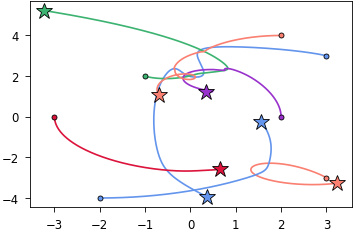

In [6]:
fig, ax = plt.subplots(figsize=(3, 2))
colors = ["C" + str(i) for i in range(7)]
y = scipy_solution.y.T
for x1, x2, color in zip(y[:, 0:7].T, y[:, 7:14].T, colors):
    plt.plot(x1, x2, color=color, marker="None")
    plt.plot(x1[0], x2[0], marker=".", color=color)
    plt.plot(x1[-1], x2[-1], marker="*", markersize=10, color=color)
plt.show()

In [7]:
# Some helper functions


def impl_to_method_config(impl, *, key, label):
    return strategy_to_method_config(filters.filter(*impl), key=key, label=label)


def strategy_to_method_config(strategy, *, key, label):
    solver = ivpsolvers.solver_dynamic(*strategy)
    return workprecision.MethodConfig(
        method={"solver": solver},
        label="ProbDiffEq: " + label,
        key=key,
        jit=True,
        plotting_kwargs={"color": "C0"},
    )


def jax_method_config():
    return workprecision.MethodConfig(
        method={},
        label="JAX: Dormand-Prince",
        jit=True,
        tols_static=True,
        key="jax",
        plotting_kwargs={"color": "C1"},
    )


def diffrax_method_config(solver, label):
    return workprecision.MethodConfig(
        method={"solver": solver},
        label="Diffrax: " + label,
        jit=True,
        key="diffrax",
        plotting_kwargs={"color": "C3"},
    )


def scipy_method_config(method):
    return workprecision.MethodConfig(
        method={"method": method},
        label="SciPy: " + method,
        jit=False,
        key="scipy",
        plotting_kwargs={"color": "C2"},
    )

In [8]:
# The second order solvers receive one additional derivative
# to match the "highest derivative" in the state-space model
# to those that transform the IVP into first-order form
num_derivatives = 4

ts0_iso_low = recipes.ts0_iso(num_derivatives=num_derivatives)
ts0_iso_low_2nd = recipes.ts0_iso(ode_order=2, num_derivatives=num_derivatives + 1)
ts0_iso_low_2nd_high = recipes.ts0_iso(ode_order=2, num_derivatives=num_derivatives + 4)

# Methods
methods = [
    diffrax_method_config(solver=diffrax.Tsit5(), label="Tsit5()"),
    diffrax_method_config(solver=diffrax.Dopri8(), label="Dopri8()"),
    impl_to_method_config(
        ts0_iso_low_2nd,
        key="probdiffeq-second",
        label=f"IsoTS0({num_derivatives+1}, 2nd)",
    ),
    impl_to_method_config(
        ts0_iso_low_2nd_high,
        key="probdiffeq-second",
        label=f"IsoTS0({num_derivatives+4}, 2nd)",
    ),
    impl_to_method_config(
        ts0_iso_low, key="probdiffeq-first", label=f"IsoTS0({num_derivatives}, 1st)"
    ),
    scipy_method_config(method="RK45"),
    scipy_method_config(method="Radau"),
    scipy_method_config(method="DOP853"),
    jax_method_config(),
]

In [9]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

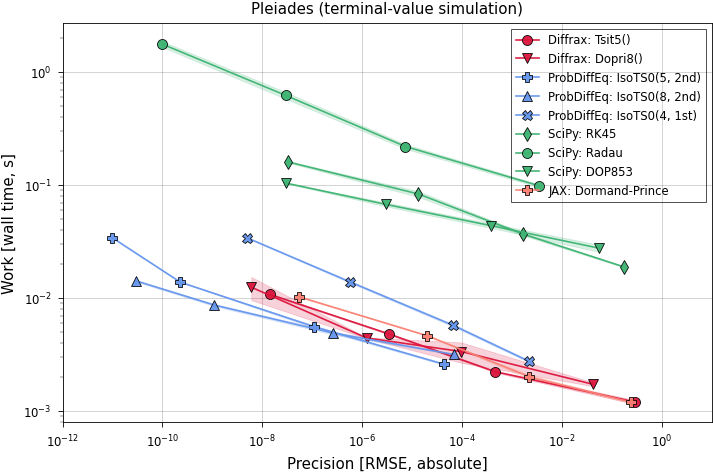

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = workprecision.plot(
    results=results,
    fig=fig,
    ax=ax,
    title=problem_config.label,
    xlabel_unit=problem_config.error_unit,
)
ax.set_xlim((1e-12, 1e1))
plt.show()